# Introduction to Neural Networks and Keras

Deep learning models layer simple machine learning models and trains the composition jointly, so that earlier layers can learn features which are useful to later layers. 

The simplest neural network is the **multilayer perceptron** (MLP). Consider a set of training data of the form $\{(\mathbf{x}_1,\mathbf{y}_1), \ldots, (\mathbf{x}_n,\mathbf{y}_n)\}$ where each input $\mathbf{x}_i$ is in $\mathbb{R}^p$ and each output $\mathbf{y}_i$ is in $\mathbb{R}^q$. The idea of the MLP is to model the input-output relationship as a function which alternately applies linear transformations (of the form $A(\mathbf{x}) = W\mathbf{x} + \mathbf{b}$) and component-wise applications of the nonlinear _ReLU_ function $\operatorname{ReLU}(x) = \max(0,x)$. We call this nonlinear function the model's **activation function**. The **depth** of the neural network is the number of layers. 

Here's a simple example, illustrated three ways: (1) in Python, (2) using a vector-based **computational graph**, and (3) using a component-based computational graph. 

In [25]:
import numpy as np
def ReLU(x):
    return np.maximum(0,x)
x  = np.array([1,-2,3])
W1 = np.array([[4,2,-1],[5,-2,-2]])
b1 = np.array([0,1])
W2 = np.array([[0,1],[-2,2],[3,4],[-2,0]])
b2 = np.array([-1,-7,-14,-5])
W3 = np.array([[-2,3,-6,4],[-1,0,-1,0]])
b3 = np.array([14, 4])
output = W3 @ ReLU(W2 @ ReLU(W1 @ x + b1) + b2) + b3
output, np.linalg.norm(output - np.array([3,2]))

(array([-1, -1]), 5.0)

<img src="nn.png">
<img src="nodes-nn.png">

_**Exercise**. Why is it necessary to include a nonlinear function like ReLU for a MLP's expressive power to increase as the depth is increased?_ 

## Training

The next task is to identify parameters such that the model accurately reflects the input-output relationship for a given set of data. This is done using called **backpropagation**. The idea is to measure the error (or **loss**) of an output value $\widehat{\mathbf{y}}$ given the desired output $\mathbf{y}$ and take the derivative of this error value with respect to each of the weights in the model. These derivatives can be averaged over a set of training samples, and that information can be used to nudge each weight in a direction that decreases average error. 

_**Exercise**. Compute a rough estimate of the derivative of the loss in the example above with respect to the top-left entry of $W_1$ by changing that value by a small amount and determining the resulting change in loss. Based on that information, should the value in that position be adjusted up or down (to decrease the loss)?_

For classification problems, it's common practice to let the number of dimensions in the last layer to be equal to the number of classes (so that each node corresponds to a particular class) and apply the **softmax** function* at that layer so that the output values are nonnegative and sum to 1. 

*The softmax function exponentiates each entry of a vector and then divides each entry by the sum of all of the entries: 

In [29]:
a = np.exp(np.array([1,2,-3])) # exponentiate
a /= np.sum(a) # normalize
a

array([0.26762315, 0.72747516, 0.00490169])

We interpret the values as confidence values, or *probabilities*, for each class. For example, a neural network which returns the vector `a` (above) for a particular input would be expressing a strong belief that that input is not in the third class, and is more likely to be in the second class than the first. 

Usually when we use softmax in the last layer of a classification problem, we also use the *cross-entropy loss* function, which returns the natural logarithm of the reciprocal of the value in the position of the correct class. For example, if the correct class were 2 and the neural network output `a`, the loss would be $-\log(0.727) = 0.319$, while a correct class of 3 would result in a much larger penalty of $-\log(0.0049) = 5.32$. 

## Keras

Keras is a Python module (built into the `tensorflow` module) that supports convenient layer-by-layer model building and automatic differentiation for training. Let's see a neural network in action. 

This example draws from the notebook at https://www.tensorflow.org/tutorials/keras/basic_classification

In [48]:
from tensorflow.keras.datasets import fashion_mnist

In [49]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [50]:
X_train.shape

(60000, 28, 28)

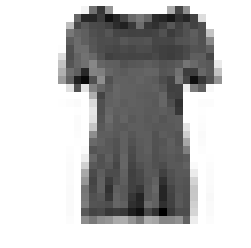

In [66]:
import matplotlib.pyplot as plt
plt.imshow(X_train[10,:,:], cmap=plt.cm.binary)
plt.axis('off')
plt.show()